**Name:** Byaravalli Arun Suhag

**EID:** 53265857

# CS4487 - Tutorial 7
## Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use linear dimensionality reduction on face images, and then train a classifier for face recognition.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import IPython.utils.warn as warn
random.seed(100)

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## 1. Loading Data and Pre-processing
We first need to load the images.  Download `olivetti.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64L, 64L)


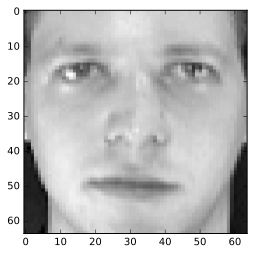

In [3]:
print img[0].shape
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

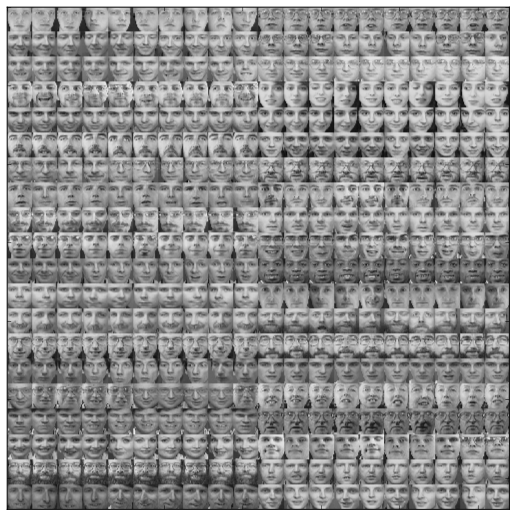

In [4]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [5]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print trainX.shape
print testX.shape

(320L, 4096L)
(80L, 4096L)


# 2. Linear Dimensionality Reduction - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA oon the data using 9 principal components.

In [6]:
### INSERT YOUR CODE HERE
pca = decomposition.PCA(n_components=9)
W   = pca.fit_transform(trainX)  # returns the coefficients

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean



The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [7]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn    = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn    = model.mean_
    elif cname == 'NMF':
        KK = model.n_components_
        comps = model.components_
        mn    = None
    K = KK
    if mn is not None:
        K += 1        
    nr = ceil(K/5.0)
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8,nr*2))
    if mn is not None:
        plt.subplot(nr,5,sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

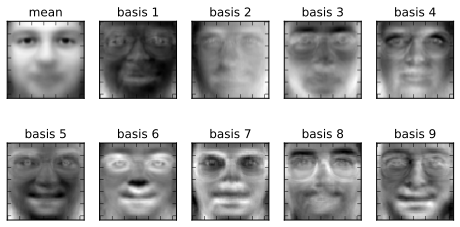

In [8]:
# run the function
plot_basis(pca, imgsize)

_ What do the basis images look like? Do some basis images correspond to particular facial features?_
- **The basis images look similar to a human face and has key features like eyes, nose , mouth and face structure that are needed for face detection. Some basis images like 7 and 9 have alot of similarity to the original image before applying PCA**

### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated PCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  _You do not need to do cross-validation for the number of components._  Calculate the average training and testing accuracies.  Remember to transform the test data into the PCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

### Logistic Regression

In [9]:
pca = decomposition.PCA(n_components=9)
WtrainX  = pca.fit_transform(trainX)  # returns the coefficients

WtestX   = pca.transform(testX)  # returns the coefficients

v = pca.components_  # the principal component vector
m = pca.mean_ 

In [10]:
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
logreg.fit(WtrainX, trainY)
print "w=", logreg.coef_
print "b=", logreg.intercept_

w= [[ -6.56806452e-01   5.95125633e-01   1.75712344e-01   1.94792082e-01
   -1.28753933e+00   8.84882272e-01   3.36331100e-01  -1.60413557e+00
   -4.18482608e-01]
 [ -7.40767143e-02  -2.51878099e-01   5.29563158e-01  -2.66691528e-01
   -2.96609443e-01   4.10754402e-01  -6.01700923e-01  -9.95987434e-01
    3.28492444e-01]
 [  1.41685717e-04   5.18921435e-04  -2.23974915e-03  -4.38414933e-04
   -2.34405208e-04   1.17562862e-03  -1.49387169e-03   1.21785674e-03
    9.55700178e-05]
 [ -1.35606713e-03   1.55598598e-04   4.53476184e-04  -1.61752562e-04
   -3.98106129e-04   1.62835894e-04  -1.62586131e-03  -2.54397884e-04
    4.70074050e-04]
 [ -8.58619376e-04   9.70283814e-04  -9.57494092e-04   7.82015949e-04
    1.64274527e-03   2.06524452e-04   3.91215823e-04  -4.02212109e-04
    2.84086660e-04]
 [ -7.72698046e-01  -8.62867795e-02   1.09069725e-02   5.20526917e-01
    1.11579451e+00   2.32301080e-01  -3.83741908e-01  -3.38175827e-01
    2.70415125e-01]
 [ -6.02075088e-01  -6.05203530e-03  

test accuracy  = 0.7
C =  [  1.62377674e+00   2.33572147e-01   1.00000000e-04   1.00000000e-04
   1.00000000e-04   6.15848211e-01   6.15848211e-01   2.33572147e-01
   4.28133240e+00   6.15848211e-01   6.15848211e-01   6.15848211e-01
   4.28133240e+00   1.62377674e+00   4.28133240e+00   2.33572147e-01
   6.15848211e-01   6.15848211e-01   1.62377674e+00   7.84759970e+01
   1.00000000e-04   2.33572147e-01   4.28133240e+00   2.33572147e-01
   1.00000000e-04   4.28133240e+00   1.62377674e+00   1.12883789e+01
   6.15848211e-01   2.97635144e+01   6.15848211e-01   1.62377674e+00
   2.33572147e-01   2.33572147e-01   2.33572147e-01   6.15848211e-01
   2.33572147e-01   1.62377674e+00   1.12883789e+01   1.62377674e+00]


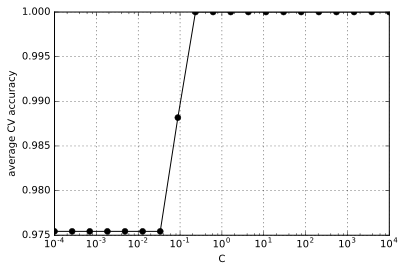

In [11]:
# predict from the model
predYtest = logreg.predict(WtestX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtest)
print "test accuracy  =", acc

print "C = ", logreg.C_

# calculate the average score for each C
avgscores = mean(logreg.scores_[1],0)  # 1 is the class label
plt.figure()
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C'); plt.ylabel('average CV accuracy')
plt.grid(True);

### Linear SVC

In [12]:
paramgrid = {'C': [1, 10, 100, 1000] }
print paramgrid

# setup the cross-validation object
# pass the SVM object, parameter grid, and number of CV folds
svcLiner = grid_search.GridSearchCV(svm.LinearSVC(), paramgrid, cv=5)
svcLiner.fit(WtrainX, trainY)

{'C': [1, 10, 100, 1000]}


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [13]:
predYtest = svcLiner.predict(WtestX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtest)
print "test accuracy  =", acc


test accuracy  = 0.75


### Finding the best number of components
Now try a range of number of components for PCA to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plot of PCA dimension vs. test accuracy.

### Logistic regression

Log Reg max at C = 26 at Accuracy = 0.9500000


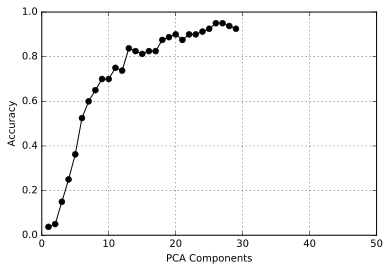

In [14]:
components = []
accuracy = []
for comp in range(1,30):
    pca = decomposition.PCA(n_components=comp)
    trainW = pca.fit_transform(trainX)

    testW = pca.transform(testX)
    
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
    logreg.fit(trainW, trainY)
    
    predY = logreg.predict(testW)
    
    acc = metrics.accuracy_score(predY, testY)
    
    components.append(comp)
    
    accuracy.append(acc)
    
maxind = accuracy.index(max(accuracy))
logPC = components[maxind]
logPA = accuracy[maxind]
plt.figure()
plt.plot(components, accuracy, 'ko-')
plt.ylim((0,1))
plt.xlim((0,50))
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
print "Log Reg max at C = %s at Accuracy = %0.7f" % (str(logPC), logPA)
plt.show()

### Linear SVC

SVC max at C = 36 at Accuracy = 0.9500000


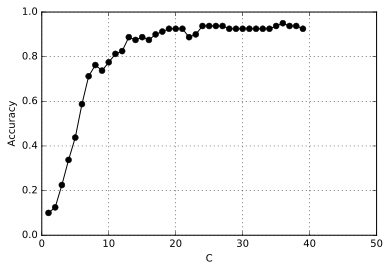

In [15]:
components = []
accuracy = []
for comp in range(1,40):
    pca = decomposition.PCA(n_components=comp)
    trainW = pca.fit_transform(trainX)

    testW = pca.transform(testX)
    
    parameter = [{'C': [1, 10, 100, 1000]}]
    clf = grid_search.GridSearchCV(svm.LinearSVC(), parameter, cv=5, n_jobs=-1)
    clf.fit(trainW, trainY)
    
    predY = clf.best_estimator_.predict(testW)
    
    acc = metrics.accuracy_score(predY, testY)
    
    components.append(comp)
    
    accuracy.append(acc)
    
maxind = accuracy.index(max(accuracy))
svcPC = components[maxind]
svcPA = accuracy[maxind]
plt.figure()
plt.plot(components, accuracy, 'ko-')
plt.xlim((0,50))
plt.ylim((0,1))
plt.xlabel('C');
plt.ylabel('Accuracy')
plt.grid(True)
print "SVC max at C = %s at Accuracy = %0.7f" % (str(svcPC), svcPA)
plt.show()

_What is the best number of components?  View the basis images to see what they look like_
- **The best number of components for logistic regression model is 26 **
- **The best number of components for linear SVC is 36 **
- **Find the code below for displaying the basi images.**

In [16]:
### Print all the basis images to analysis

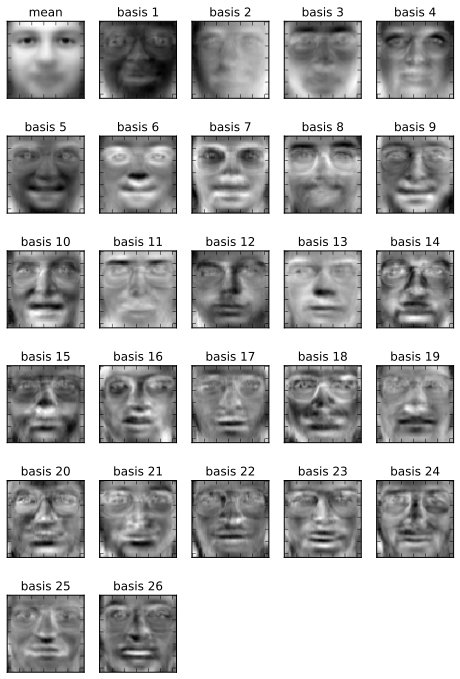

In [17]:
### PCA for Logistic regression (best accuracy)
pca = decomposition.PCA(n_components=logPC)
trainW = pca.fit_transform(trainX)
testW = pca.transform(testX)
# For Logistic Regression
plot_basis(pca, imgsize)

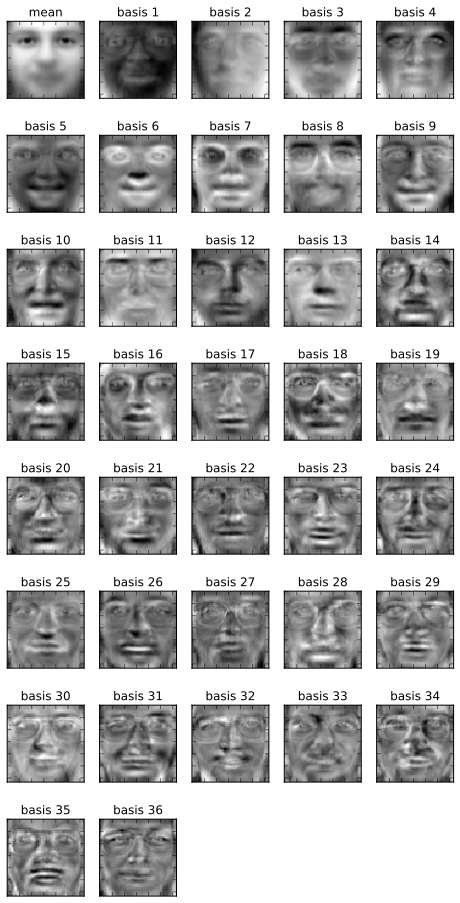

In [18]:
## PCA for linear SVC(best accuracy)
pca = decomposition.PCA(n_components=svcPC)
trainW = pca.fit_transform(trainX)
testW = pca.transform(testX)
# For Logistic Regression
plot_basis(pca, imgsize)

# 3. Linear Dimensionality Reduction - NMF
Now we will repeat the experiment using non-negative matrix factorization instead of PCA.  Perform NMF with 9 components and visualize the basis images.

Accuracy = 0.6500000


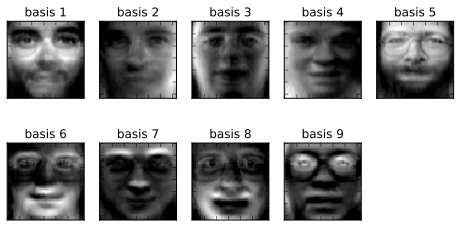

In [19]:
### INSERT YOUR CODE HERE
nmf = decomposition.NMF(n_components = 9)
trainN = nmf.fit_transform(trainX)
testN = nmf.transform(testX)

logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)

logreg.fit(trainN, trainY)

predY = logreg.predict(testN)

print "Accuracy = %0.7f" % (metrics.accuracy_score(predY, testY))
plot_basis(nmf, imgsize)

_What do the basis images look like?  What is the main difference with the PCA basis images?_
- **The basis images look similar to a human face and has key features like eyes, nose , mouth and face structure that are needed for face detection. This is similar to the PCA basis images in depicting the features of a face. Some basis images like 5 and 8 have alot of similarity to the original image before applying PCA**

- **The main difference between PCA and NMF from just looking at the image is that NMF contains less nosie compared to PCA basis images**

### Finding the best number of components
Now find the number of components that gives the best test accuracy.  Use the same type of classifier that you used in the previous experiment.  Use cross-validation to select the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components.

### Logistic Regression

Logistic Regression max at C = 17 at Accuracy = 0.9250000


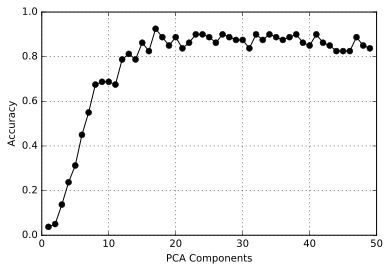

In [20]:
components = []
accuracy = []
for comp in range(1,50):
    nmf = decomposition.NMF(n_components = comp)
    trainN = nmf.fit_transform(trainX)
    testN = nmf.transform(testX)
    
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
    logreg.fit(trainN, trainY)
    
    predY = logreg.predict(testN)
    
    acc = metrics.accuracy_score(predY, testY)
    
    components.append(comp)
    
    accuracy.append(acc)
    
maxind = accuracy.index(max(accuracy))
logNC = components[maxind]
logNA = accuracy[maxind]
plt.figure()
plt.plot(components, accuracy, 'ko-')
plt.ylim((0,1))
plt.xlim((0,50))
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
print "Logistic Regression max at C = %s at Accuracy = %0.7f" % (str(logNC), logNA)
plt.show()

### Linear SVC

SVC max at C = 19 at Accuracy = 0.9375000


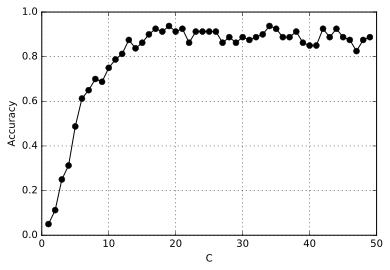

In [21]:
components = []
accuracy = []
for comp in range(1,50):
    nmf = decomposition.NMF(n_components = comp)
    trainN = nmf.fit_transform(trainX)
    testN = nmf.transform(testX)
    
    parameter = [{'C': [1, 10, 100, 1000]}]
    clf = grid_search.GridSearchCV(svm.LinearSVC(), parameter, cv=5, n_jobs=-1)
    clf.fit(trainN, trainY)
    
    predY = clf.best_estimator_.predict(testN)
    
    acc = metrics.accuracy_score(predY, testY)
    
    components.append(comp)
    
    accuracy.append(acc)
    
maxind = accuracy.index(max(accuracy))
svcNC = components[maxind]
svcNA = accuracy[maxind]
plt.figure()
plt.plot(components, accuracy, 'ko-')
plt.xlim((0,50))
plt.ylim((0,1))
plt.xlabel('C');
plt.ylabel('Accuracy')
plt.grid(True)
print "SVC max at C = %s at Accuracy = %0.7f" % (str(svcNC), svcNA)
plt.show()

_Which number of components give the best test result? How does the accuracy compare to the best PCA result?  Why is NMF or PCA better?_
- **the summary of the results that include the number of components for each reduction model is below**
- **The accuracy of a linear classifier using PCA or NMF are almost similar. **
- **PCA slightly out performs the NMF**

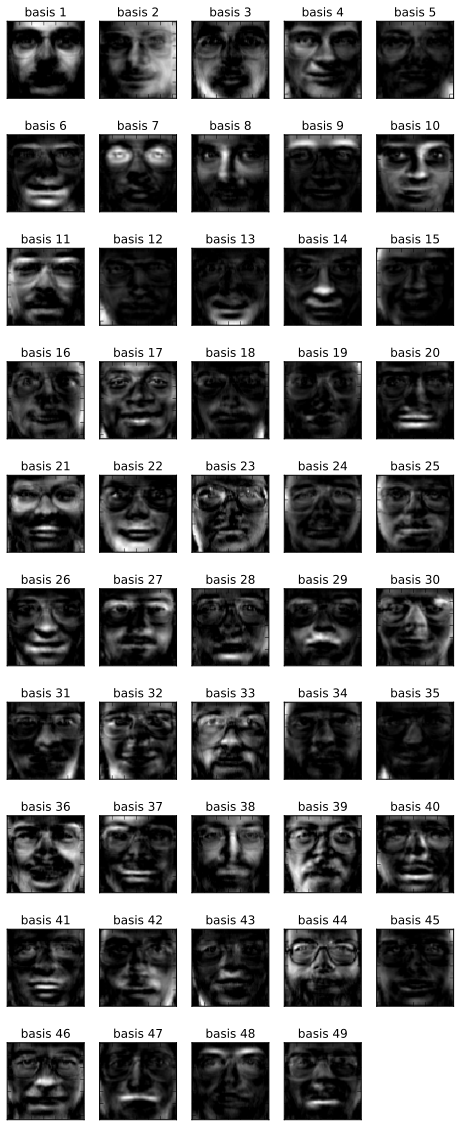

In [22]:
### INSERT YOUR CODE HERE
nmf = decomposition.NMF(n_components = comp)
trainN = nmf.fit_transform(trainX)
testN = nmf.transform(testX)
# For Logistic Regression
plot_basis(nmf, imgsize)

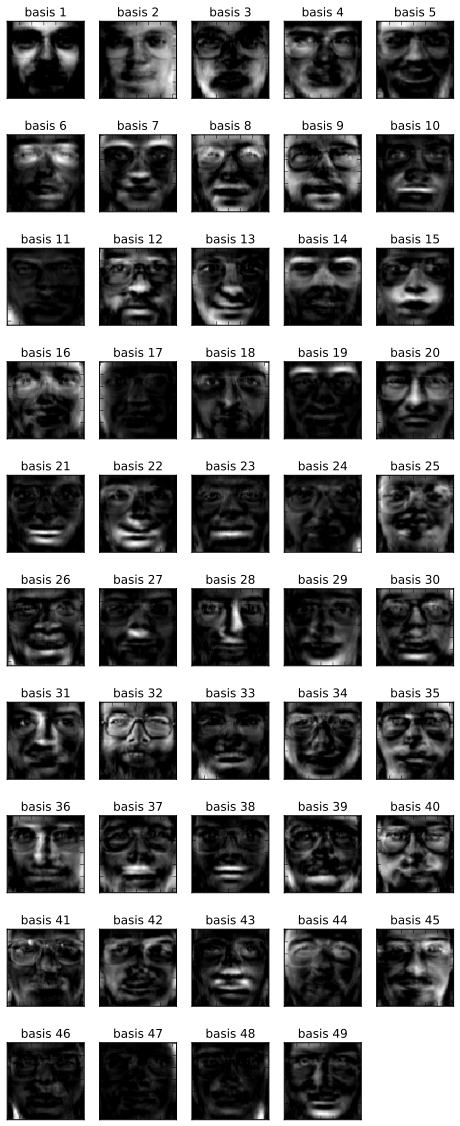

In [23]:
nmf = decomposition.NMF(n_components = comp)
trainN = nmf.fit_transform(trainX)
testN = nmf.transform(testX)
# For Logistic Regression
plot_basis(nmf, imgsize)

In [25]:
print "Accuracy of PCA on the best Logistic Regression with 26 components = %0.5f" % (logPA)
print "Accuracy of PCA on the best Support Vector Classifier with 36 components = %0.5f" % (svcPA)
print "Accuracy of NMF on the best Logistic Regression with 49 components = %0.5f" % (logNA)
print "Accuracy of NMF on the best Support Vector Classifier with 49 components = %0.5f" % (svcNA)

Accuracy of PCA on the best Logistic Regression with 26 components = 0.95000
Accuracy of PCA on the best Support Vector Classifier with 36 components = 0.95000
Accuracy of NMF on the best Logistic Regression with 49 components = 0.92500
Accuracy of NMF on the best Support Vector Classifier with 49 components = 0.93750
